# Models Pipeline

In this notebook we create a pipeline that with minimal tuning can configure a new job that runs and saves the output models in the models output folder, that helps us take these pre-trained model and conduct analysis on them.

## Generic Imports

In [135]:
import os
import json
import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlopen

## Text Preparation Imports

In [136]:
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
import re
from nltk.corpus import stopwords
from keras.preprocessing.sequence import pad_sequences

In [137]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/asoliman/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Neural Networks Imports

In [138]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Dropout
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.callbacks import EarlyStopping

# Reading the Dataset

In [139]:
def representation(dataframe):
    value_counts = dataframe['reviewerGender'].value_counts()
    category_value_counts = dataframe['category'].value_counts()
    print('Gender Representation')
    print('----')
    print('Males: {}'.format(value_counts['male']))
    print('Females: {}'.format(value_counts['female']))
    print('Percentage of males in the dataset equals {}%'.format(round(value_counts['male']/len(dataframe)*100,2)))
    print('Percentage of females in the dataset equals {}%'.format(round(value_counts['female']/len(dataframe)*100,2)))
    print()
    print('Category Representation')
    print('----')
    print('Electronics Category: {}'.format(category_value_counts['electronics']))
    print('Clothing Category: {}'.format(category_value_counts['clothing']))
    print('Percentage of Electronics Category in the dataset equals {}%'.format(round(category_value_counts['electronics']/len(dataframe)*100,2)))
    print('Percentage of Clothing Category in the dataset equals {}%'.format(round(category_value_counts['clothing']/len(dataframe)*100,2)))
    
def cross_representation(dataframe):
    value_counts = dataframe.groupby(["reviewerGender", "category"]).size()
    print('Cross Representation')
    print('Male electronics reviewers: {}'.format(value_counts['male']['electronics']))
    print('Male clothing reviewers: {}'.format(value_counts['male']['clothing']))
    print('Female electronics reviewers: {}'.format(value_counts['female']['electronics']))
    print('Female clothing reviewers: {}'.format(value_counts['female']['clothing']))

In [140]:
df = pd.read_csv('merged_data_equally_sampled_cat_gender.csv')

In [141]:
representation(df)

Gender Representation
----
Males: 800000
Females: 800000
Percentage of males in the dataset equals 50.0%
Percentage of females in the dataset equals 50.0%

Category Representation
----
Electronics Category: 800000
Clothing Category: 800000
Percentage of Electronics Category in the dataset equals 50.0%
Percentage of Clothing Category in the dataset equals 50.0%


In [142]:
cross_representation(df)

Cross Representation
Male electronics reviewers: 400000
Male clothing reviewers: 400000
Female electronics reviewers: 400000
Female clothing reviewers: 400000


# Prepare Data for RNN

In [143]:
df = df[df['reviewText'].notnull()]
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
def clean_text(text):
    """
        text: a string
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

In [144]:
df = df.reset_index(drop=True)
df['reviewText'] = df['reviewText'].apply(clean_text)
df['reviewText'] = df['reviewText'].str.replace('\d+', '')

In [145]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 25000
# Max number of words in each review.
MAX_SEQUENCE_LENGTH = 150
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['reviewText'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 449255 unique tokens.


In [146]:
def prep_for_training(dataframe, target='reviewerGender'):
    X = tokenizer.texts_to_sequences(dataframe['reviewText'].values)
    X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
    print('Shape of data tensor:', X.shape)
    Y = pd.get_dummies(dataframe[target]).values
    print('Shape of label tensor:', Y.shape)
    return X,Y

In [149]:
X, Y = prep_for_training(df,'category')

Shape of data tensor: (1599997, 150)
Shape of label tensor: (1599997, 2)


In [150]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.1, random_state = 414421)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(1439997, 150) (1439997, 2)
(160000, 150) (160000, 2)


In [153]:
def LSTM_Model():
    model = Sequential()
    model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(EMBEDDING_DIM, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    return model

In [154]:
epochs = 5
batch_size = 256

model = LSTM_Model()
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
model.save('models/keyword-classification')

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 150, 100)          2500000   
_________________________________________________________________
spatial_dropout1d_8 (Spatial (None, 150, 100)          0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 202       
Total params: 2,580,602
Trainable params: 2,580,602
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
5063/5063 [==============================] - 974s 192ms/step - loss: 0.2172 - accuracy: 0.8968 - val_loss: 0.1765 - val_accuracy: 0.9154
Epoch 2/5
5063/5063 [==============================] - 971s 192ms/step - loss: 0.1708 - ac

In [155]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

5000/5000 [==============================] - 51s 10ms/step - loss: 0.1696 - accuracy: 0.9196
Test set
  Loss: 0.170
  Accuracy: 0.920


In [156]:
X, Y = prep_for_training(df,'reviewerGender')
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.1, random_state = 414421)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

Shape of data tensor: (1599997, 150)
Shape of label tensor: (1599997, 2)
(1439997, 150) (1439997, 2)
(160000, 150) (160000, 2)


In [157]:
epochs = 5
batch_size = 256

model = LSTM_Model()
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
model.save('models/gender-classification')

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 150, 100)          2500000   
_________________________________________________________________
spatial_dropout1d_9 (Spatial (None, 150, 100)          0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 202       
Total params: 2,580,602
Trainable params: 2,580,602
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
5063/5063 [==============================] - 973s 192ms/step - loss: 0.6143 - accuracy: 0.6596 - val_loss: 0.5890 - val_accuracy: 0.6858
Epoch 2/5
5063/5063 [==============================] - 970s 192ms/step - loss: 0.5827 - ac

In [158]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

5000/5000 [==============================] - 52s 10ms/step - loss: 0.5938 - accuracy: 0.6876
Test set
  Loss: 0.594
  Accuracy: 0.688


In [26]:
model = keras.models.load_model('models/keyword-classification')

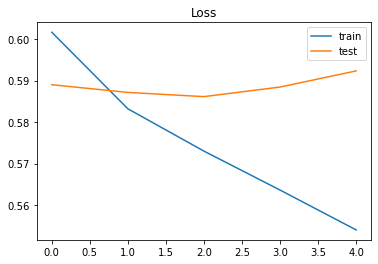

In [159]:
def draw_loss(history):
    plt.title('Loss')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()
draw_loss(history)

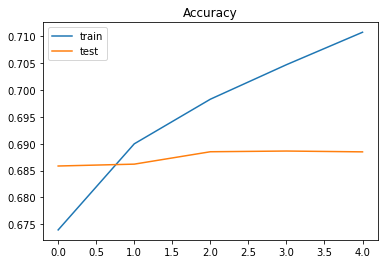

In [160]:
def draw_accuracy(history):
    plt.title('Accuracy')
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='test')
    plt.legend()
    plt.show()

draw_accuracy(history)

# Removal of Keywords

In [161]:
def split_text(text):
    text = text.split()[:500]
    return text

df['review'] = df.reviewText.apply(clean_text)
df['review'] = df.reviewText.apply(split_text)

In [162]:
df.head()

reviewerGender  Unnamed: 1      reviewerID        asin    reviewerName  \
0         female      480769  A30BVXPPOFSLPS  B000FNFSPY           Nikki   
1         female      331446  A3VCOKMQOCUNGX  B0007M0VXM  Kiley Phillips   
2         female     6522422  A1IUYKR1UISDBD  B00J0CT2GW  Lori Gilhooley   
3         female     6058996  A2EWF2OWK60DJW  B01GES2QOY           Julia   
4         female     2604690   AIT7A7K8IMXBR  B007G2J1JG  Threasa Walton   

                                          reviewText reviewerFirstName  \
0  impressed get pay  gets intermitten usage seam...             Nikki   
1  burning  dvds  coaster impressed speed overall...             Kiley   
2  best headphones ever owned amazing sound charg...              Lori   
3  love sound produce awesome theater eperience w...             Julia   
4                                               good           Threasa   

  reviewerGender.1     category  \
0           female  electronics   
1           female  electronics   
2           female  electronics   
3           female  electronics   
4           female  electronics   

                                              review  
0  [impressed, get, pay, gets, intermitten, usage...  
1  [burning, dvds, coaster, impressed, speed, ove...  
2  [best, headphones, ever, owned, amazing, sound...  
3  [love, sound, produce, awesome, theater, eperi...  
4                                             [good]

In [163]:
X_train, X_test, y_train, y_test = train_test_split(df.review, df.category, test_size=0.1, random_state=42, stratify=df.category)

In [164]:
def create_idf_dict(series):
    dictionary = dict()
    for bag_of_words in series:
        no_duplicates = list(dict.fromkeys(bag_of_words))
        #print(no_duplicates)
        for word in no_duplicates:
            insert(dictionary, word)
    return dictionary

def insert(dictionary, word):
    if word in dictionary:
        dictionary[word] += 1
    else:
        dictionary[word] = 1

def build_feature_matrix(reviews, f_words):
    fm = list()
    for review in reviews:
        counter = Counter(review)
        fm.append([counter[word] for word in f_words.index])
    fm_df = pd.DataFrame(data=fm, index=reviews.index, columns=f_words.index)
    nwords = reviews.apply(lambda text: len(text))
    fm_df = fm_df.div(nwords, axis=0)
    # for i in range(len(data)):
    #     counter = Counter(data.X.iloc[i])
    #     fm.iloc[i] = [counter[word] for word in f_words]
    fm_df = fm_df * f_words.scores
    return fm_df

def gender_table(df, gender="female"):
    # computes in how many docs word occur (just once per doc) 
    # for clothing:
    
    col_cloth = f"clothing_{gender}"
    X_train = df[(df.reviewerGender == gender) & (df.category == "clothing")]
    count_word_dict_clothing = create_idf_dict(X_train.review)
    idf_scores_clothing = pd.DataFrame.from_dict(count_word_dict_clothing, orient="index")
    idf_scores_clothing.columns = [col_cloth]
    idf_scores_clothing = idf_scores_clothing.sort_values(by=col_cloth, ascending=False)[:50000]
    
    # for electrnoics
    col_elec = f"electronics_{gender}"
    X_train = df[(df.reviewerGender == gender) & (df.category == "electronics")]
    count_word_dict_elec = create_idf_dict(X_train.review)
    idf_scores_elec = pd.DataFrame.from_dict(count_word_dict_elec, orient="index")
    idf_scores_elec.columns = [col_elec]
    idf_scores_elec = idf_scores_elec.sort_values(by=col_elec, ascending=False)[:50000]
    

    # inner join and calculate ratio
    idf_scores = idf_scores_clothing.join(idf_scores_elec, how="inner")
    idf_scores = (idf_scores/len(df))*100000
    idf_scores[f"ratio_{gender}"] = idf_scores[col_cloth] / idf_scores[col_elec]
    #idf_scores[f"ratio_{gender}"] = idf_scores[f"ratio_{gender}"].apply(lambda x: 1/x if x > 1 else x)
    
    return idf_scores

idf_scores_female = gender_table(df, "female")
idf_scores_male = gender_table(df, "male")
idf_scores = idf_scores_female.join(idf_scores_male, how="inner")
idf_scores["diff"] = np.abs(idf_scores.ratio_male - idf_scores.ratio_female)
#idf_scores.sort_values(by="ratio")

In [165]:
MIN_ERROR = 0.2

idf_scores[(idf_scores.ratio_male < (1/MIN_ERROR)) & (idf_scores.ratio_male >MIN_ERROR)]

clothing_female  electronics_female  ratio_female  clothing_male  \
love           4900.946689         3275.693642      1.496155    2492.754674   
great          4532.508498         6906.575450      0.656260    5300.384938   
fit            4526.008486         1448.940217      3.123668    4310.758083   
size           3628.194303          841.314077      4.312533    2719.630099   
like           3241.506078         3593.944239      0.901936    3106.568325   
...                    ...                 ...           ...            ...   
preaching         0.062500            0.250000      0.250000       0.187500   
workforce         0.062500            0.437501      0.142857       0.250000   
upc               0.062500            0.812502      0.076923       0.312501   
retuning          0.062500            0.562501      0.111111       0.187500   
purchasea         0.062500            0.437501      0.142857       0.187500   

           electronics_male  ratio_male      diff  
love            1360.752551    1.831894  0.335739  
great           6609.262392    0.801963  0.145703  
fit             1194.002239    3.610343  0.486675  
size             786.126474    3.459533  0.853000  
like            3429.006429    0.905967  0.004032  
...                     ...         ...       ...  
preaching          0.312501    0.600000  0.350000  
workforce          0.312501    0.800000  0.657143  
upc                1.125002    0.277778  0.200855  
retuning           0.625001    0.300000  0.188889  
purchasea          0.625001    0.300000  0.157143  

[13109 rows x 7 columns]

In [166]:
# MIN_ERROR: If review gets categorized based on a specific word, the error is at least MIN_ERROR

# Example: word "tv" has ratio 0.015, so if a review containes "tv", the error (missclassification rate) is 0.015, 
# which is below MIN_ERROR=0.2, so it gets removed.   

MIN_ERROR = 0.5
without_clothing = idf_scores[(idf_scores.ratio_male < (1/MIN_ERROR)) | (idf_scores.ratio_female < (1/MIN_ERROR))]
without_elec = idf_scores[(idf_scores.ratio_male > MIN_ERROR) | (idf_scores.ratio_female > MIN_ERROR)]
without_keywords = idf_scores[(idf_scores.index.isin(without_clothing.index)) & ((idf_scores.index.isin(without_elec.index)))]
without_keywords

clothing_female  electronics_female  ratio_female  clothing_male  \
love           4900.946689         3275.693642      1.496155    2492.754674   
great          4532.508498         6906.575450      0.656260    5300.384938   
like           3241.506078         3593.944239      0.901936    3106.568325   
nice           2561.254802         2047.878840      1.250687    2808.442766   
good           2524.754734         4040.070075      0.624928    4081.820153   
...                    ...                 ...           ...            ...   
terror            0.062500            0.500001      0.125000       0.312501   
prise             0.062500            0.187500      0.333333       0.187500   
timeto            0.062500            0.500001      0.125000       0.250000   
preaching         0.062500            0.250000      0.250000       0.187500   
workforce         0.062500            0.437501      0.142857       0.250000   

           electronics_male  ratio_male      diff  
love            1360.752551    1.831894  0.335739  
great           6609.262392    0.801963  0.145703  
like            3429.006429    0.905967  0.004032  
nice            1993.253737    1.408974  0.158287  
good            4963.696807    0.822335  0.197406  
...                     ...         ...       ...  
terror             0.250000    1.250000  1.125000  
prise              0.250000    0.750000  0.416667  
timeto             0.312501    0.800000  0.675000  
preaching          0.312501    0.600000  0.350000  
workforce          0.312501    0.800000  0.657143  

[8139 rows x 7 columns]

In [167]:
def prep_for_training_without_keywords(dataframe, without, target='reviewerGender'):
    new_tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
    new_tokenizer.fit_on_texts(list(without.index))
    X = new_tokenizer.texts_to_sequences(dataframe.review.values)
    X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
    print('Shape of data tensor:', X.shape)
    Y = pd.get_dummies(dataframe[target]).values
    print('Shape of label tensor:', Y.shape)
    return X,Y

In [168]:
X, Y = prep_for_training_without_keywords(df, without_keywords, 'category')
X

Shape of data tensor: (1599997, 150)
Shape of label tensor: (1599997, 2)


array([[  0,   0,   0, ...,  46,  66,  47],
       [  0,   0,   0, ...,  23, 183, 126],
       [  0,   0,   0, ..., 128,  41,  31],
       ...,
       [  0,   0,   0, ...,  88,  31, 671],
       [  0,   0,   0, ...,   0,   0,  11],
       [  0,   0,   0, ...,   0,   0,  10]], dtype=int32)

In [169]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.1, random_state = 414421)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(1439997, 150) (1439997, 2)
(160000, 150) (160000, 2)


In [170]:
model = LSTM_Model()
epochs = 5
batch_size = 256

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
model.save('models/keyword-classification-without-product-keywords-0.5')

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 150, 100)          2500000   
_________________________________________________________________
spatial_dropout1d_10 (Spatia (None, 150, 100)          0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 202       
Total params: 2,580,602
Trainable params: 2,580,602
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
5063/5063 [==============================] - 970s 191ms/step - loss: 0.5733 - accuracy: 0.6885 - val_loss: 0.5304 - val_accuracy: 0.7204
Epoch 2/5
5063/5063 [==============================] - 967s 191ms/step - loss: 0.5230 - a

In [171]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

5000/5000 [==============================] - 52s 10ms/step - loss: 0.4977 - accuracy: 0.7434
Test set
  Loss: 0.498
  Accuracy: 0.743


In [172]:
X, Y = prep_for_training_without_keywords(df, without_keywords, 'reviewerGender')

Shape of data tensor: (1599997, 150)
Shape of label tensor: (1599997, 2)


In [173]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.1, random_state = 414421)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(1439997, 150) (1439997, 2)
(160000, 150) (160000, 2)


In [174]:
model = LSTM_Model()
epochs = 5
batch_size = 256

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
model.save('models/gender-classification-without-product-keywords-0.5')

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 150, 100)          2500000   
_________________________________________________________________
spatial_dropout1d_11 (Spatia (None, 150, 100)          0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 202       
Total params: 2,580,602
Trainable params: 2,580,602
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
5063/5063 [==============================] - 970s 191ms/step - loss: 0.6491 - accuracy: 0.6129 - val_loss: 0.6359 - val_accuracy: 0.6292
Epoch 2/5
5063/5063 [==============================] - 968s 191ms/step - loss: 0.6345 - a

In [132]:
X, Y = prep_for_training(df, 'reviewerGender')

Shape of data tensor: (1599997, 150)
Shape of label tensor: (1599997, 2)


In [133]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.1, random_state = 414421)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(1439997, 150) (1439997, 2)
(160000, 150) (160000, 2)


In [ ]:
model = LSTM_Model()
epochs = 5
batch_size = 256

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
model.save('models/gender-classification')

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 150, 100)          2500000   
_________________________________________________________________
spatial_dropout1d_6 (Spatial (None, 150, 100)          0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 202       
Total params: 2,580,602
Trainable params: 2,580,602
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
5063/5063 [==============================] - 973s 192ms/step - loss: 0.6148 - accuracy: 0.6585 - val_loss: 0.5894 - val_accuracy: 0.6850
Epoch 2/5
5063/5063 [==============================] - 970s 192ms/step - loss: 0.5832 - ac